# Social networks - communities and important users

In this project, we are interested in learning about structures within social networks. Among millions of users, can we identify communities? Can we find out which users have a special role or are especially important within these communities? 

In this notebook, I'll guide you through the output of a Java program which I wrote as part of an open-ended capstone project of the MOOC specialization *Object Oriented Java Programming: Data Structures and Beyond* on [Coursera.org](https://www.coursera.org/specializations/java-object-oriented). 

First, we will try to assess how important users are in a network of over 80000 Twitter users, based on their in-degree centrality and Page-Rank score. In the second part we will try to identify communities within the Facebook data of 783 UC San Diego students, using the Girvan-Newmann algorithm.

In [1]:
# libraries for data handling
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# libraries for plotting
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

### Important users on Twitter
Twitter is an interesting network to study because it can be represented by a directed graph. Not all users who follow someone are being followed back. Some important or influential people may have a lot more followers, meaning a lot more incoming edges. 

That's something that can be easily quantified, e.g. by a user's in-degree centrality (how many followers?). But maybe one wants to consider certain users as more important if they are followed by other important users. That's the idea of Google's famous Page-Rank algorithm which considers how much of its own score each user contributes to the score of another user. Both these scores are computed by the Java code in this project.

The anonymous Twitter data we have here is is a social circle data set from the SNAP database and can be found [here](https://snap.stanford.edu/data/ego-Twitter.html). The graph contains 81306 vertices and 1768149 edges.

We load the data for each users in-degree centrality and Page-Rank score, which was generated by the Java program in this project, and we scale both scores between 0 and 100 so that both quantities are comparable.

In [2]:
# load the data
df_tw = pd.read_csv("data/Analysis/twitterIDCPR.txt",
                    header=None,names=["userID","idc","pr"])
# scale both in-degree centrality and page rank score between 0 and 100
df_tw["idc_sc"] = df_tw.idc/(df_tw.idc.max()-df_tw.idc.min())*100
df_tw["pr_sc"] = df_tw.pr/(df_tw.pr.max()-df_tw.pr.min())*100
# calculate difference between these quantities
df_tw["dif"] = df_tw.idc_sc-df_tw.pr_sc
df_tw.head()

,userID,idc,pr,idc_sc,pr_sc,dif
0,162269614,0.000135,0.000006,0.325251,0.325251,2.067656e-07
1,15335662,0.000578,0.000027,1.389710,1.389709,1.529399e-06
2,207752295,0.000775,0.000036,1.862803,1.862800,3.526781e-06
3,47186647,0.000086,0.000004,0.206978,0.206978,2.570261e-07
4,49152745,0.000061,0.000003,0.147842,0.147841,2.888567e-07


We can observe that almost all users have a very low in-degree centrality and Page-Rank score and only very few users have very high scores. That agrees with the intuition that most users are just "normal people" who use the network to connect with their friends and only very few users can be considered as influential or important individuals.

In [3]:
# put the scaled quantities in bins
idc = pd.cut(df_tw.idc_sc,bins=100,labels=range(1,101)).value_counts().sort_index()
idc.index.name = "IDC"
pr = pd.cut(df_tw.pr_sc,bins=100,labels=range(1,101)).value_counts().sort_index()
print("Most user have very low in-degree centrality, only very few users have a high one:")
display(idc.head(),idc.tail())

Most user have very low in-degree centrality, only very few users have a high one:


IDC
1    68630
2     7614
3     2365
4     1026
5      529
Name: idc_sc, dtype: int64

IDC
96     1
97     0
98     0
99     0
100    1
Name: idc_sc, dtype: int64

We can also see that the differences between in-degree centrality and Page-Rank score are very small. Since most users have very low scores, contributions from "important" users to other "important" user which make them even more important (the basic idea of the Page-Rank algorithm), seem to be irrelevant here.

In [4]:
print("Range of difference between users' IDC and PR: {}".format(df_tw.dif.max()-df_tw.dif.min()))

Range of difference between users' IDC and PR: 0.0010903840476815113


Both these observations, low scores for most users, and almost no difference between these score metrics, become clearer when they are plotted (on a log scale).

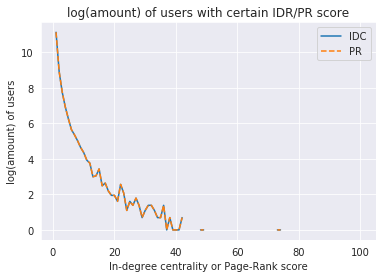

In [5]:
# plot on a log x scale
fig, ax = plt.subplots()
ax.plot(range(1,101),np.log(idc),label="IDC")
ax.plot(range(1,101),np.log(pr),"--",label="PR")
ax.set_title("log(amount) of users with certain IDR/PR score")
ax.set_ylabel("log(amount) of users")
ax.set_xlabel("In-degree centrality or Page-Rank score")
_ = ax.legend()
plt.savefig("data/Figures/userIDCPR.png",dpi=300)

We have seen that on this Twitter data, it is easy to identify the few important users in this network by either in-degree centrality or Page-Rank.

### Communities on Facebook
Presumably, users are parts of many kinds of social communities on Facebook, e.g. you may be connected to many of your current and former coworkers and you may be the only connection between these groups. This follows the idea that there are many connections within communities and fewer among communities. Hence, the edges between communities are passed by many shortest paths between users which means the betweenness centrality of these edges is high. 

The Girvan-Newmann algorithm tries to separate a network into communities by cutting these edges with high betweenness centrality. It calculates edge betweenness centrality for every edge and then removes the one with the highest score. This procedure is repeated until the desired number of communities is identified, or all the way down until all edges are removed and only single users/vertices remain.

The anonymous Facebook data we have here is is a "snapshot" of the network of students from the University of California in San Diego (UCSD) in 2005. The data was kindly provided by the hosts of the MOOC specialization *Object Oriented Java Programming: Data Structures and Beyond* on [Coursera.org](https://www.coursera.org/specializations/java-object-oriented). The graph contains 783 vertices and 1892 edges and is only a small fraction of the original data (due to limitations in computational power).

We load the data of the network before community detection.

In [6]:
# load graph from file
G = nx.read_edgelist("data/Analysis/facebook_1000.txt",nodetype=int,data=False,create_using=nx.Graph)
print("Vertices: {}".format(len(G.nodes())))
print("Edges: {}".format(len(G.edges())))

Vertices: 783
Edges: 1892


Let's visualize the original network. We can see that most people seem to have many connections with many other people but there are also some users on the outskirts of this network who are connected to only a few other users. 

/home/pascal/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


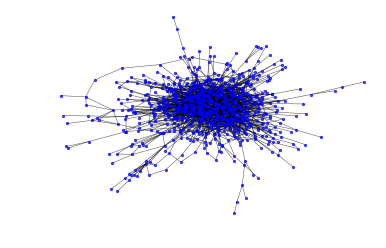

In [7]:
# plot the original network
fig, ax = plt.subplots()
nx.draw(G,with_labels=False,node_size=5,node_color="b",alpha=0.7,width=0.5,)
plt.savefig("data/Figures/origFB.png",dpi=300)

Now let's load the graph after running the Girvan-Newmann algorithm and identifying 30 communities (by removing 451 edges).

In [8]:
# load the new graph from file
G2 = nx.read_edgelist("data/Analysis/fbComAll.txt",nodetype=int,data=True,create_using=nx.Graph)
print("Vertices: {}".format(len(G2.nodes())))
print("Edges: {}".format(len(G2.edges())))

Vertices: 783
Edges: 1441


We can also calculate the degree centrality for each user/vertex.

In [9]:
# calculate degree centrality for each node
idc = nx.degree_centrality(G2)
nx.set_node_attributes(G2, idc, 'idc')

Let's plot the identified communities and use the users' degree centrality for color-mapping.

/home/pascal/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


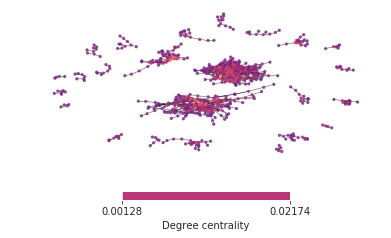

In [14]:
# prepare a color map
colors = np.array([n[1]["idc"] for n in G2.nodes(data=True)])
vmin = colors.min()-0.01
vmax = colors.max()
cmap = plt.cm.magma
# plot the new graph containing the communities
fig, ax = plt.subplots()
nx.draw(G2,with_labels=False,node_size=5,node_color=colors
        ,alpha=0.7,width=0.5,cmap=cmap,vmin=vmin,vmax=vmax)
# add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap,norm=None)
sm.set_array([])
cbar = plt.colorbar(sm,orientation="horizontal",shrink=0.5,
                    boundaries=[colors.min(),colors.max()])
_ = cbar.ax.set_xlabel("Degree centrality")
plt.savefig("data/Figures/comsFB.png",dpi=300)

We can see that the Girvan-Newmann algorithm identified two very large communities and a couple of smaller communities. Within the larger communities, there are several users that have a high degree centrality, suggesting that they are more important or  influential within these communities. Since the data we use here is anonymized, we can only speculate about the nature of these communities. Maybe they represent student unions, study and sport clubs, or people in different degree programs. 

In a real example, we could now look into what it is that the users in these communities have in common. When working with real social network data, community detection algorithms and user-importance metrics can help us to look for patterns, connections, and trends in these networks with millions of users.

Thanks a lot for going through this interesting project with me!